In [1]:
%env WORKDIR ~/Documents/weatherpy-work/

import sys
sys.path.append('..')

from wxdata import stormevents

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from wxdata.plotting import (
    simple_basemap, sample_colors, plot_cities, LegendBuilder, plot_points, 
    plot_cities_with_geocodor, top_right_textbox, bottom_right_textbox
)
from wxdata.utils import datetime_buckets
from wxdata.extras import st_clusters
from wxdata.stormevents import tors

env: WORKDIR=~/Documents/weatherpy-work/


## Load the tornado data for 4/14/12 and find the clusters

In [2]:
df = stormevents.tornadoes('2012-04-14 12:00', '2012-04-15 12:00', tz='UTC')

In [3]:
clusters = st_clusters(df, eps_km=60, eps_min=60, min_samples=15)

## Prolific Southern Supercell: ~Woodward - Wichita

In [198]:
clust4 = clusters.clusters[4]
clust4.summary()

{'center': (37.17572088353416, -97.88072550200805),
 'max_time': Timestamp('2012-04-15 05:06:00+0000', tz='UTC'),
 'min_time': Timestamp('2012-04-14 22:18:00+0000', tz='UTC'),
 'size': 249,
 'time_spread': Timedelta('0 days 06:48:00')}

In [320]:
importlib.reload(tors)

<module 'wxdata.stormevents.tornprocessing' from '../wxdata/stormevents/tornprocessing.py'>

In [259]:
from wxdata import radar
radar_order = radar.Level2Archive()

In [334]:
radarfiles = radar_order.select_around('KVNX', '2012-04-15 02:20').download()

In [341]:
def describe_clust(clust):
    description = clust.describe_tors()
    parts = description.split('\n')
    if 'UTC' not in parts[0]:
        parts[0] += ' UTC'
    parts[0] = 'Time range: ' + parts[0]
    return '\n'.join(['Cluster information: '] + parts)

def time_progression_label(a, b):
    return '{} to {} UTC'.format(a.strftime('%H:%M'), b.strftime('%H:%M'))

def plot_bg_tornadoes(cluster_groups, foreground_clust, basemap):
#     shadow = path_effects.SimpleLineShadow(offset=(1, -1), alpha=0.4)
    plot_kw = dict(color='gray', linewidth=2, alpha=0.6, patheffect=None)
    
    for clust in cluster_groups.clusters:
        if clust != foreground_clust:
            tors.plot_tornadoes(clust.events, basemap, **plot_kw)
    tors.plot_tornadoes(cluster_groups.noise.events, basemap, **plot_kw)

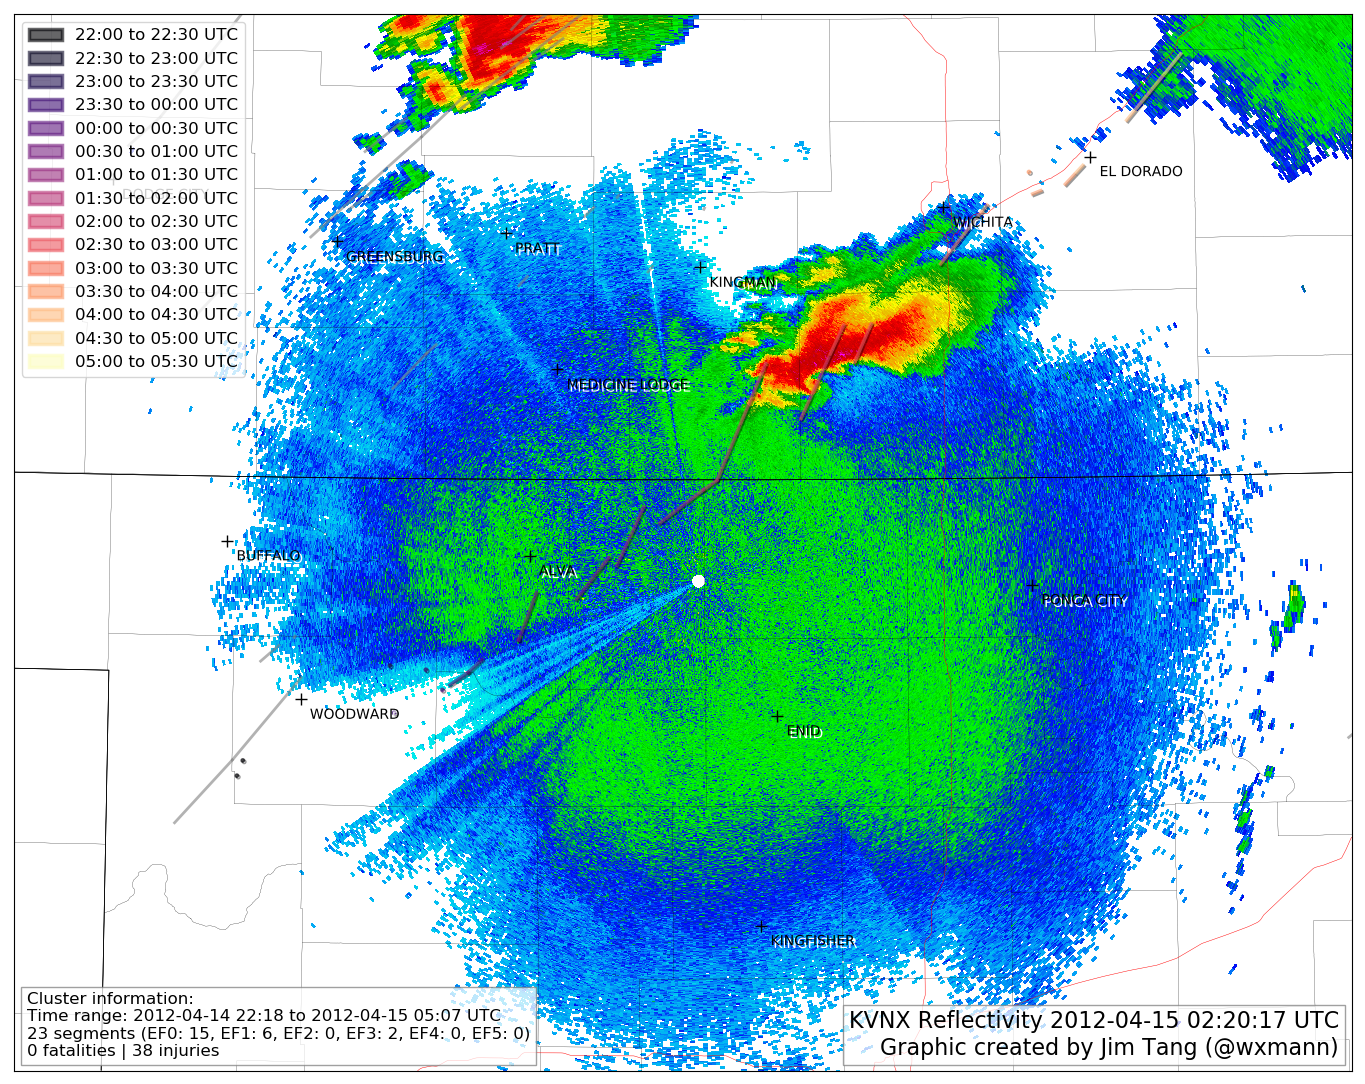

In [354]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(18, 14), dpi=100)

min_time = pd.Timestamp('2012-04-14 22:00+0000')
max_time = pd.Timestamp('2012-04-15 05:30+0000')
dt = pd.Timedelta('30 min')
time_buckets = datetime_buckets(min_time, max_time, dt)

_, display = radar.plot_reflectivity(radarfiles[0], zoom_km=(190, 150), shift_latlon=(0.1, -0.05))

shadow = path_effects.SimpleLineShadow(offset=(1, -1), alpha=0.4)
leg = LegendBuilder(loc=2, fontsize='large')
tors.plot_time_progression(clust4.events, display.basemap, time_buckets, patheffect=shadow,
                           cmap='magma', linewidth=2.5, alpha=0.6,
                           legend=leg, legend_handle_func=time_progression_label)

plot_bg_tornadoes(clusters, clust4, display.basemap)
plotting.bottom_left_textbox(fig.axes[0], describe_clust(clust4), fontsize='large')

wm = 'KVNX Reflectivity {}\nGraphic created by Jim Tang (@wxmann)'.format(
    radar.timestamp_from_filename(radarfiles[0]).strftime('%Y-%m-%d %H:%M:%S') + ' UTC')
plotting.bottom_right_textbox(fig.axes[0], wm) 

ks_cities = ['Wichita, KS', 'Medicine Lodge, KS', 'Dodge City, KS', 
             'Pratt, KS', 'El Dorado, KS', 'Kingman, KS', 'Greensburg, KS']

ok_cities = ['Woodward, OK', 'Ponca City, OK', 'Kingfisher, OK', 'Enid, OK',
            'Alva, OK', 'Buffalo, OK']

highlighter = path_effects.withSimplePatchShadow(offset=(2, -2), alpha=1.0, 
                                                 shadow_rgbFace='white')
plotting.plot_cities_with_geocodor(ks_cities + ok_cities, display.basemap, 
                                  dx=0.03, dy=-0.05, alpha=1.0, labelsize=10,
                                  patheffect=[highlighter])